In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from IPython.display import display, Markdown
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud


In [92]:
csv_path = 'dataset/descriptions'
csv_files = [os.path.join(csv_path, f) for f in os.listdir(csv_path) if f.endswith('.csv')]
dfs = [pd.read_csv(csv_file) for csv_file in csv_files]

combined_df = pd.concat(dfs, ignore_index=True)

**TOTAL # of Images** = 4,040

**TOTAL # of References** = 4,775

**MAX # of References to single image** = 78

**Mean # of References to single image** = 1.182

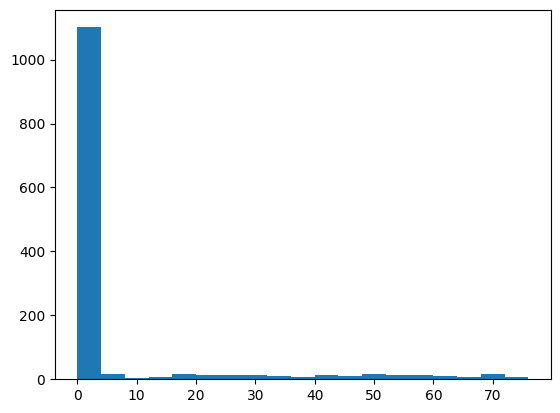

In [93]:
total_references = sum(len(eval(ref)) for ref in combined_df['Reference'])
max_references = max(len(eval(ref)) for ref in combined_df['Reference'])
mean_references = np.mean([len(eval(ref)) for ref in combined_df['Reference']])
n_images = len(combined_df)

display(Markdown(f"**TOTAL # of Images** = {n_images:,}"))
display(Markdown(f"**TOTAL # of References** = {total_references:,}"))
display(Markdown(f"**MAX # of References to single image** = {max_references:,}"))
display(Markdown(f"**Mean # of References to single image** = {mean_references:,.3f}"))


num_refs_per_image = [len(ref) for ref in combined_df['Reference']]
plt.hist(num_refs_per_image, bins=range(0, 80, 4))
plt.show()

**TOTAL # of Words** = 97,662

**TOTAL # Unique Words** = 6,933

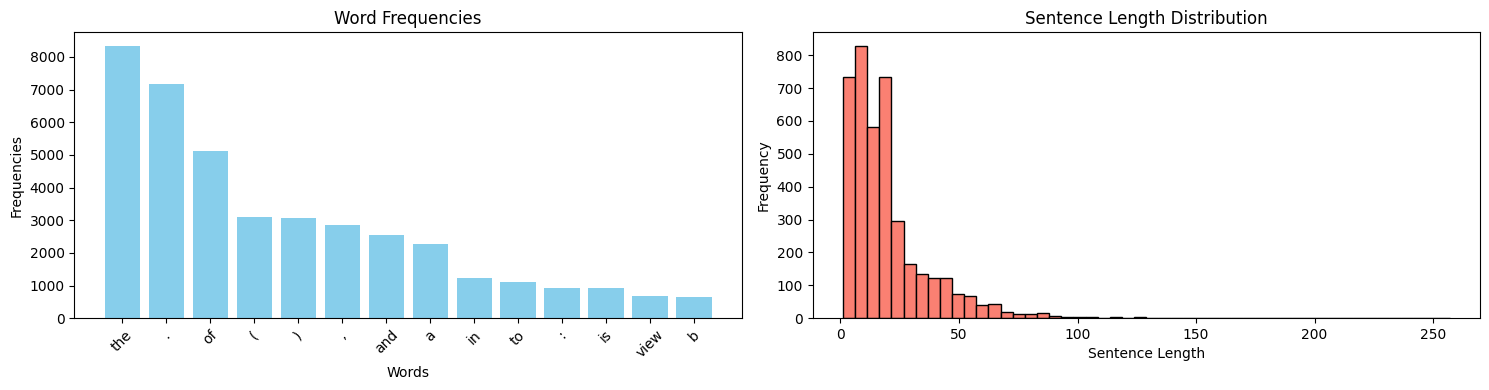

In [96]:
sentences = combined_df['Description'].array
lowercase_sentences = [str(sentence).lower() for sentence in sentences]
tokenized_sentences = [word_tokenize(sentence) for sentence in lowercase_sentences]

all_words = [word for sentence in tokenized_sentences for word in sentence]
display(Markdown(f"**TOTAL # of Words** = {len(all_words):,}"))

word_freq = Counter(all_words)
display(Markdown(f"**TOTAL # Unique Words** = {len(word_freq):,}"))

mc_10 = word_freq.most_common(14)


words, frequencies = zip(*mc_10)

sentence_lengths = [len(str(sentence).split()) for sentence in sentences]

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].bar(words, frequencies, color='skyblue')
ax[0].set_xlabel('Words')
ax[0].set_ylabel('Frequencies')
ax[0].set_title('Word Frequencies')
ax[0].tick_params(axis='x', rotation=45)

ax[1].hist(sentence_lengths, bins=50, color='salmon', edgecolor='black')
ax[1].set_xlabel('Sentence Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Sentence Length Distribution')

plt.tight_layout()
plt.show()

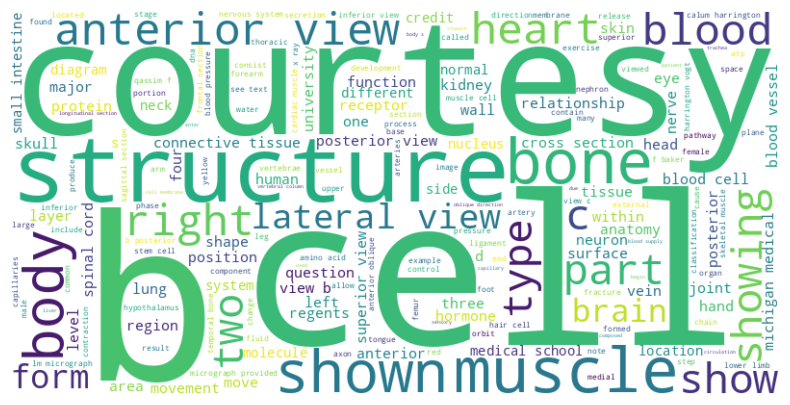

In [97]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()